# Introduction
In this lab we will be using Time series forecasting to predict the future for edmonton weather.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


In [2]:
#dtype line is added since some of the state field was missing for few countries
df = pd.read_csv('/content/city_temperature.csv',dtype={"State": str})
#Should be 2,906,327 with 8 Columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int64  
 5   Day             int64  
 6   Year            int64  
 7   AvgTemperature  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 177.4+ MB


In [3]:
#Visualization of how the dataset looks like before data processing.
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


# Missing Value Imputation

In [4]:
#Checking each column
df.isnull().sum()

,0
Region,0
Country,0
State,1450990
City,0
Month,0
Day,0
Year,0
AvgTemperature,0


In [5]:
#Drop States since it's missing and won't significantly affect the model
df.drop(["State"], axis = 1, inplace = True)
df.isnull().sum()

,0
Region,0
Country,0
City,0
Month,0
Day,0
Year,0
AvgTemperature,0


# Outlier Detection and Treatment

<Axes: ylabel='AvgTemperature'>

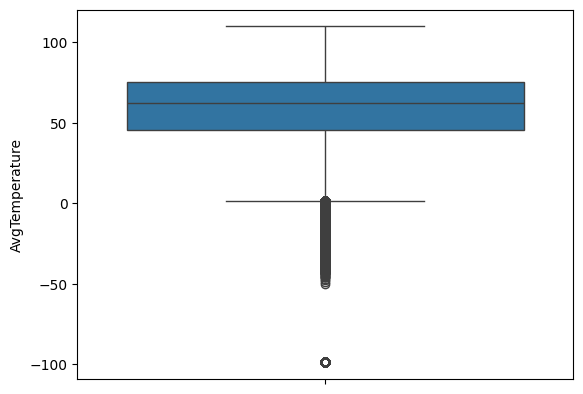

In [6]:
sns.boxplot(df["AvgTemperature"])

<ipython-input-7-82fef96f1a20>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AvgTemperature'] = (df['AvgTemperature'] - 32) * 5 / 9


<Axes: ylabel='AvgTemperature'>

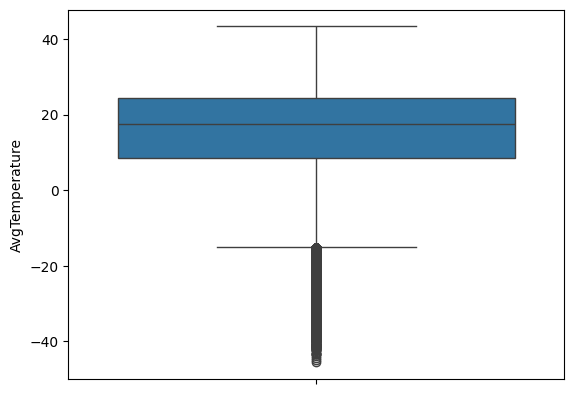

In [7]:
# Remove rows where AvgTemperature is -99
df = df[df["AvgTemperature"] != -99]
#Converting the Celsius
df['AvgTemperature'] = (df['AvgTemperature'] - 32) * 5 / 9
sns.boxplot(df["AvgTemperature"])

The box plot may look wrong but it is important to keep some of the negative temperature since we will need it to correctly predict the models. Simply doing IQR outliar treatment will remove this points so we will keep it tradional and only remore all the -99 value which assumes to be a placeholder value

# Resampling to different time frequencies

In [8]:
# Combine Year, Month, and Day into a single datetime column
df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])

# Set Date as the index (required for resampling)
df.set_index("Date", inplace=True)

# Verify the changes
df.head()

,Region,Country,City,Month,Day,Year,AvgTemperature
Date,,,,,,,
1995-01-01,Africa,Algeria,Algiers,1,1,1995,17.888889
1995-01-02,Africa,Algeria,Algiers,1,2,1995,9.666667
1995-01-03,Africa,Algeria,Algiers,1,3,1995,9.333333
1995-01-04,Africa,Algeria,Algiers,1,4,1995,8.000000
1995-01-05,Africa,Algeria,Algiers,1,5,1995,8.833333


In [9]:
#Get Edmonton Weather and Canada Weather
df_canada = df[df["Country"] == "Canada"].copy()
df_edmonton = df_canada[df_canada["City"] == "Edmonton"].copy()

df_edmonton.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7371 entries, 1995-01-01 to 2015-04-01
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Region          7371 non-null   object 
 1   Country         7371 non-null   object 
 2   City            7371 non-null   object 
 3   Month           7371 non-null   int64  
 4   Day             7371 non-null   int64  
 5   Year            7371 non-null   int64  
 6   AvgTemperature  7371 non-null   float64
dtypes: float64(1), int64(3), object(3)
memory usage: 460.7+ KB


# Feature Engineering


## Temporal Features

In [10]:
#Creating Time Features.
df_edmonton['dayofweek'] = df_edmonton.index.dayofweek
df_edmonton['quarter'] = df_edmonton.index.quarter
df_edmonton['dayofyear'] = df_edmonton.index.dayofyear
df_edmonton['weekofyear'] = df_edmonton.index.isocalendar().week
df_edmonton['SMA_90'] = df_edmonton['AvgTemperature'].rolling(90).mean()
df_edmonton['SMA_60'] = df_edmonton['AvgTemperature'].rolling(60).mean()
df_edmonton['SMA_30'] = df_edmonton['AvgTemperature'].rolling(30).mean()
df_edmonton['Yesterday_Temperature'] = (df_edmonton.index - pd.Timedelta('1 days')).map(df_edmonton['AvgTemperature'].to_dict())

df_edmonton.dropna(inplace = True)
df_edmonton.head()


,Region,Country,City,Month,Day,Year,AvgTemperature,dayofweek,quarter,dayofyear,weekofyear,SMA_90,SMA_60,SMA_30,Yesterday_Temperature
Date,,,,,,,,,,,,,,,
1995-03-31,North America,Canada,Edmonton,3,31,1995,4.277778,4,1,90,13,-7.431481,-5.556481,-2.977778,6.555556
1995-04-01,North America,Canada,Edmonton,4,1,1995,3.944444,5,2,91,13,-7.248765,-5.481481,-2.679630,4.277778
1995-04-02,North America,Canada,Edmonton,4,2,1995,5.611111,6,2,92,13,-7.035185,-5.412037,-2.033333,3.944444
1995-04-03,North America,Canada,Edmonton,4,3,1995,-8.388889,0,2,93,14,-6.913580,-5.560185,-1.642593,5.611111
1995-04-04,North America,Canada,Edmonton,4,4,1995,-4.500000,1,2,94,14,-6.760494,-5.545370,-1.075926,-8.388889


In [11]:
# Define function to determine season
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

# Apply function to create a single 'Season' column
df_edmonton["Season"] = df_edmonton["Month"].apply(get_season)

# Verify the changes
df_edmonton.head(10)



,Region,Country,City,Month,Day,Year,AvgTemperature,dayofweek,quarter,dayofyear,weekofyear,SMA_90,SMA_60,SMA_30,Yesterday_Temperature,Season
Date,,,,,,,,,,,,,,,,
1995-03-31,North America,Canada,Edmonton,3,31,1995,4.277778,4,1,90,13,-7.431481,-5.556481,-2.977778,6.555556,Spring
1995-04-01,North America,Canada,Edmonton,4,1,1995,3.944444,5,2,91,13,-7.248765,-5.481481,-2.679630,4.277778,Spring
1995-04-02,North America,Canada,Edmonton,4,2,1995,5.611111,6,2,92,13,-7.035185,-5.412037,-2.033333,3.944444,Spring
1995-04-03,North America,Canada,Edmonton,4,3,1995,-8.388889,0,2,93,14,-6.913580,-5.560185,-1.642593,5.611111,Spring
1995-04-04,North America,Canada,Edmonton,4,4,1995,-4.500000,1,2,94,14,-6.760494,-5.545370,-1.075926,-8.388889,Spring
1995-04-05,North America,Canada,Edmonton,4,5,1995,1.111111,2,2,95,14,-6.583951,-5.550926,-0.331481,-4.500000,Spring
1995-04-06,North America,Canada,Edmonton,4,6,1995,3.388889,3,2,96,14,-6.379012,-5.452778,0.383333,1.111111,Spring
1995-04-07,North America,Canada,Edmonton,4,7,1995,3.388889,4,2,97,14,-6.191975,-5.287963,1.005556,3.388889,Spring
1995-04-08,North America,Canada,Edmonton,4,8,1995,-1.333333,5,2,98,14,-5.985802,-5.251852,1.359259,3.388889,Spring


In [12]:
# Feature engineering
df_edmonton["Temp_Anomaly"] = df_edmonton["AvgTemperature"] - df_edmonton["SMA_30"]

# Encoding the 'Season' column (Winter, Spring, Summer, Fall)
df_edmonton["Season"] = df_edmonton["Season"].map({"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3})

# Drop any rows with missing values (if necessary)
df_edmonton.dropna(inplace=True)
df_edmonton.head()

,Region,Country,City,Month,Day,Year,AvgTemperature,dayofweek,quarter,dayofyear,weekofyear,SMA_90,SMA_60,SMA_30,Yesterday_Temperature,Season,Temp_Anomaly
Date,,,,,,,,,,,,,,,,,
1995-03-31,North America,Canada,Edmonton,3,31,1995,4.277778,4,1,90,13,-7.431481,-5.556481,-2.977778,6.555556,1,7.255556
1995-04-01,North America,Canada,Edmonton,4,1,1995,3.944444,5,2,91,13,-7.248765,-5.481481,-2.679630,4.277778,1,6.624074
1995-04-02,North America,Canada,Edmonton,4,2,1995,5.611111,6,2,92,13,-7.035185,-5.412037,-2.033333,3.944444,1,7.644444
1995-04-03,North America,Canada,Edmonton,4,3,1995,-8.388889,0,2,93,14,-6.913580,-5.560185,-1.642593,5.611111,1,-6.746296
1995-04-04,North America,Canada,Edmonton,4,4,1995,-4.500000,1,2,94,14,-6.760494,-5.545370,-1.075926,-8.388889,1,-3.424074


# Modeling Framework

## Data Split

In [13]:
# Sort index chronologically
df_edmonton = df_edmonton.sort_index()
df_edmonton.head()
# Now split the data
train = df_edmonton.loc[:'2014-10-01']

# Keeping a gap of 4 months to avoid lookahead through the SMA 90
test = df_edmonton.loc['2015-01-01':]

X_FEATURES = ['Month', 'Day', 'Year', 'dayofweek', 'quarter', 'dayofyear', 'weekofyear', 'SMA_90', 'SMA_60',
       'SMA_30', 'Yesterday_Temperature']

# Features (X) and target (y)
X_train = train[X_FEATURES]
y_train = train['AvgTemperature']

X_test = test[X_FEATURES]
y_test = test['AvgTemperature']


# Initialize scaler
scaler = StandardScaler()

# Fit and transform TRAINING data
X_train_scaled = scaler.fit_transform(X_train)  # Fit on train only!

# Transform TEST data using the same scaler (no fit!)
X_test_scaled = scaler.transform(X_test)  # Use train's mean/std





## Linear Regression Model

In [14]:
# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_linear = linear_model.predict(X_test_scaled)

# Calculate RMSE
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
print(f"Linear Regression RMSE: {rmse_linear}")


Linear Regression RMSE: 5.046165565664381


## Ramdom Forest Model

In [15]:
# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test_scaled)

# Calculate RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest RMSE: {rmse_rf}")


Random Forest RMSE: 5.189350033956928


## XGBoost Model


In [16]:
# Initialize and train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Calculate RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost RMSE: {rmse_xgb}")


XGBoost RMSE: 5.172125922612489


## Cross validation for Time Series forecasting

In [17]:
# TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Function for scaled cross-validation and saving predictions
def run_scaled_cv(model, X, y):
    cv_rmse = []
    all_predictions = []  # To store all predictions across folds

    for train_index, test_index in tscv.split(X):
        # Split data
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        # Scale within each fold
        scaler.fit(X_train_cv)  # Fit only on training fold
        X_train_scaled = scaler.transform(X_train_cv)
        X_test_scaled = scaler.transform(X_test_cv)

        # Train and predict
        model.fit(X_train_scaled, y_train_cv)
        y_pred = model.predict(X_test_scaled)

        # Store predictions
        all_predictions.extend(y_pred)

        # Calculate RMSE for this fold
        cv_rmse.append(np.sqrt(mean_squared_error(y_test_cv, y_pred)))

    return np.mean(cv_rmse), all_predictions  # Return both RMSE and predictions

# Linear Regression CV
time_linear_cv_rmse, time_linear_y_pred = run_scaled_cv(linear_model, X_train, y_train)
print(f"Linear Regression CV RMSE: {time_linear_cv_rmse:.4f}")
# Save predictions with "time_" prefix
time_y_pred_linear = time_linear_y_pred

# Random Forest CV
time_rf_cv_rmse, time_rf_y_pred = run_scaled_cv(rf_model, X_train, y_train)
print(f"Random Forest CV RMSE: {time_rf_cv_rmse:.4f}")
# Save predictions with "time_" prefix
time_y_pred_rf = time_rf_y_pred

# XGBoost CV
time_xgb_cv_rmse, time_xgb_y_pred = run_scaled_cv(xgb_model, X_train, y_train)
print(f"XGBoost CV RMSE: {time_xgb_cv_rmse:.4f}")
# Save predictions with "time_" prefix
time_y_pred_xgb = time_xgb_y_pred


Linear Regression CV RMSE: 3.4078
Random Forest CV RMSE: 3.6358
XGBoost CV RMSE: 3.9967


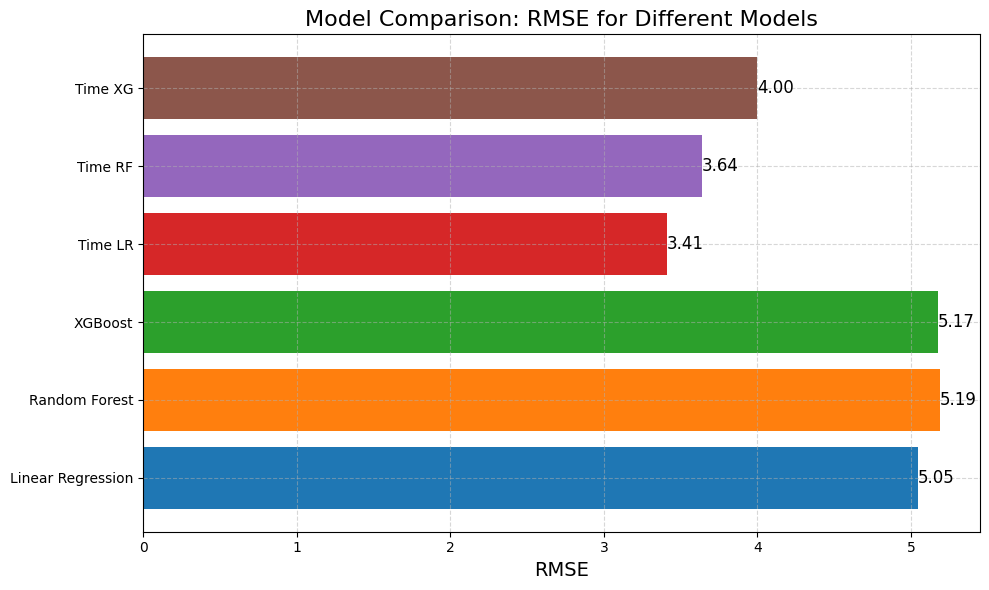

In [18]:
import matplotlib.pyplot as plt

# RMSE comparison models and values
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'Time LR', 'Time RF', 'Time XG']
rmse_values = [rmse_linear, rmse_rf, rmse_xgb, np.mean(time_linear_cv_rmse), np.mean(time_rf_cv_rmse), np.mean(time_xgb_cv_rmse)]

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(models, rmse_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])

# Add labels to bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}',
             va='center', ha='left', color='black', fontsize=12)

# Customize the plot
plt.xlabel('RMSE', fontsize=14)
plt.title('Model Comparison: RMSE for Different Models', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()


# Analysis and Visualization

## Historical Data and Predictions

### Linear Regression Model

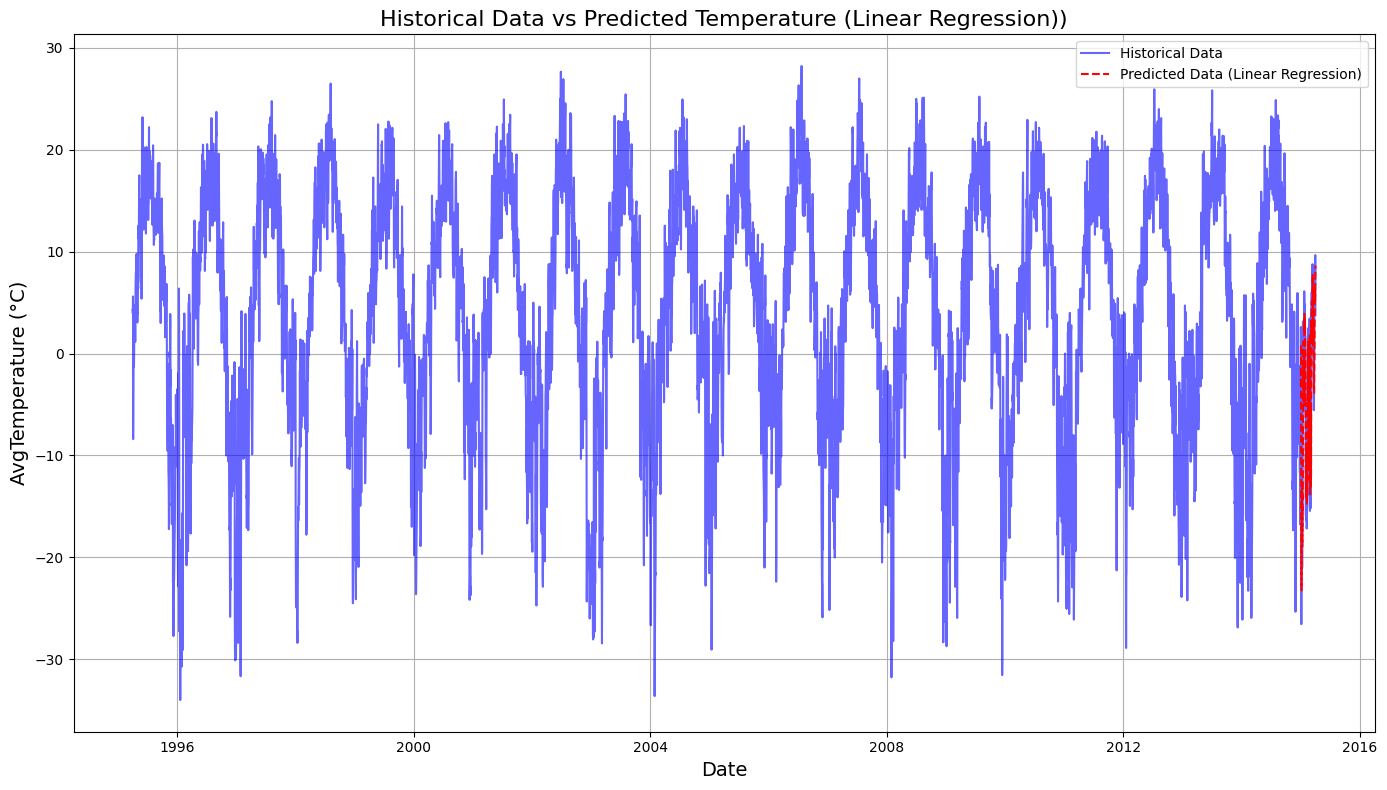

In [19]:
# Plotting Historical vs Predicted values
plt.figure(figsize=(14, 8))
plt.plot(df_edmonton.index, df_edmonton['AvgTemperature'], label='Historical Data', color='blue', alpha=0.6)
plt.plot(y_test.index, y_pred_linear, label='Predicted Data (Linear Regression)', color='red', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('AvgTemperature (°C)', fontsize=14)
plt.title('Historical Data vs Predicted Temperature (Linear Regression))', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Random Forest Model

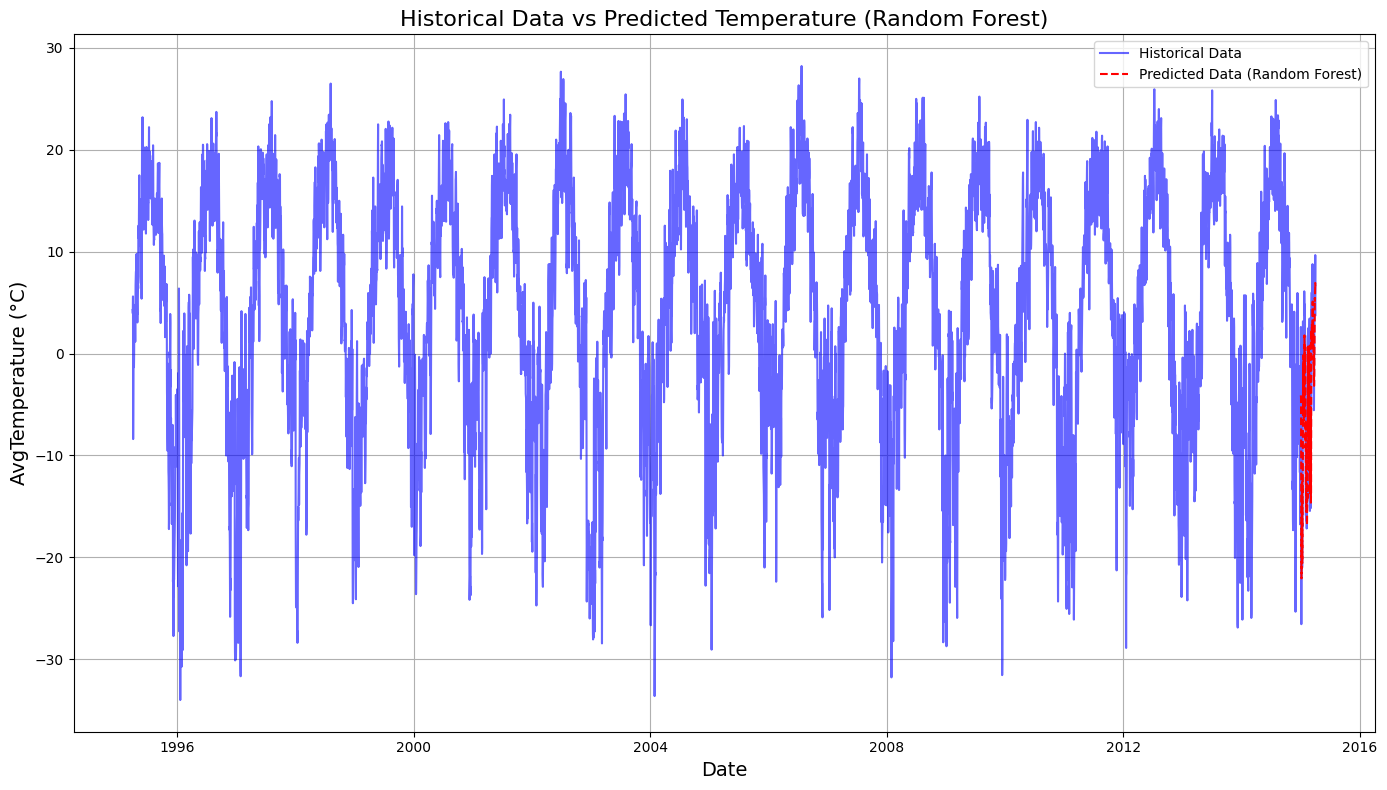

In [20]:
# Plotting Historical vs Predicted values
plt.figure(figsize=(14, 8))
plt.plot(df_edmonton.index, df_edmonton['AvgTemperature'], label='Historical Data', color='blue', alpha=0.6)
plt.plot(y_test.index, y_pred_rf, label='Predicted Data (Random Forest)', color='red', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('AvgTemperature (°C)', fontsize=14)
plt.title('Historical Data vs Predicted Temperature (Random Forest)', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### XGBoost Model

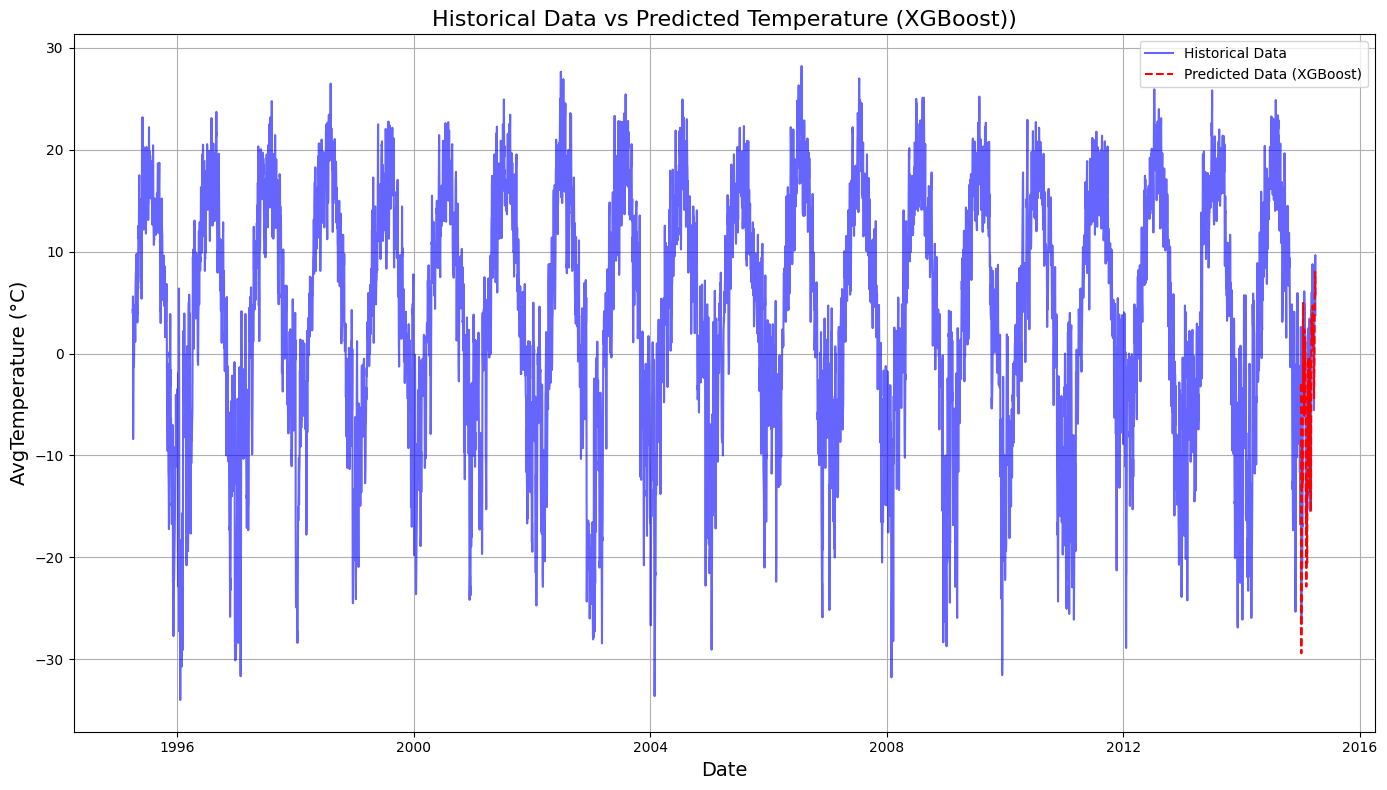

In [21]:
# Plotting Historical vs Predicted values
plt.figure(figsize=(14, 8))
plt.plot(df_edmonton.index, df_edmonton['AvgTemperature'], label='Historical Data', color='blue', alpha=0.6)
plt.plot(y_test.index, y_pred_xgb, label='Predicted Data (XGBoost)', color='red', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('AvgTemperature (°C)', fontsize=14)
plt.title('Historical Data vs Predicted Temperature (XGBoost))', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Time Series CV for Previous Models

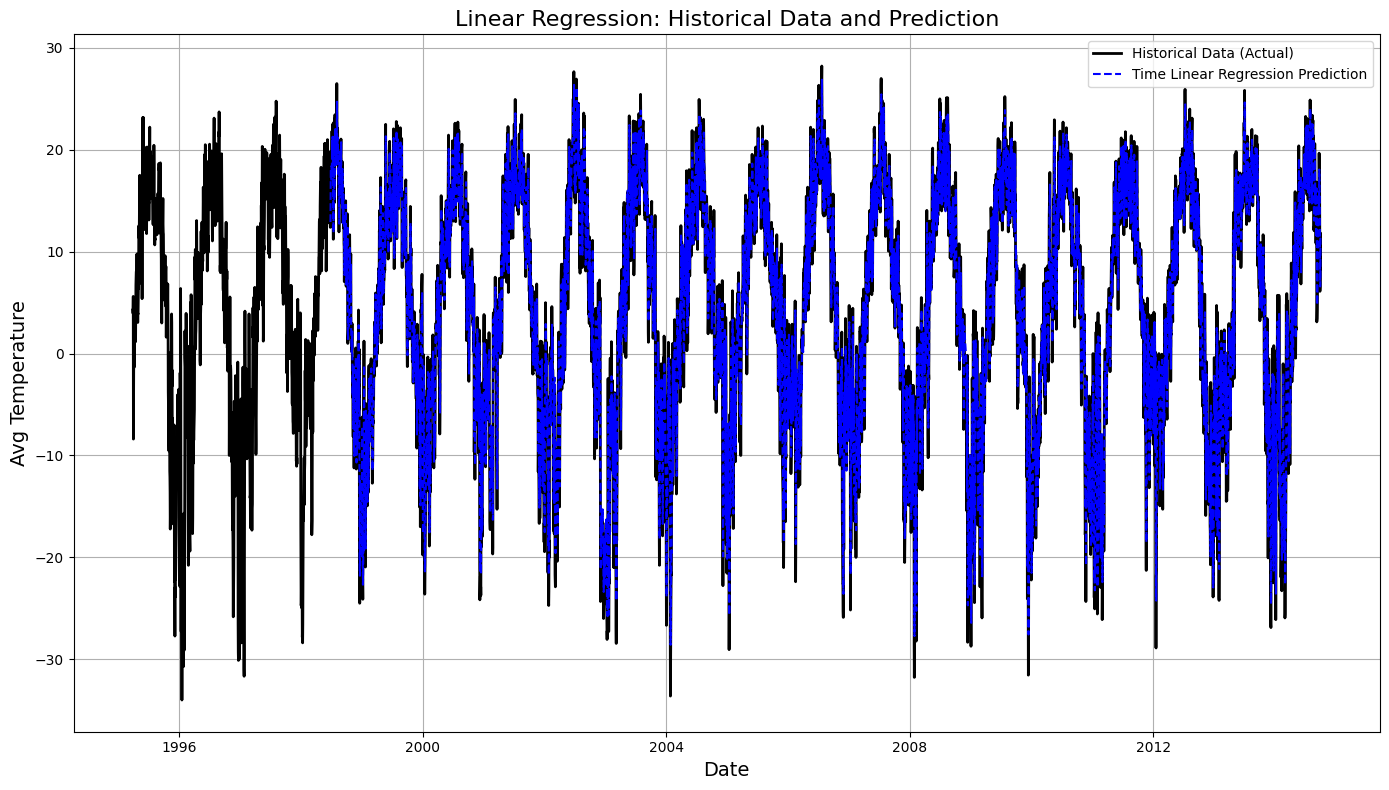

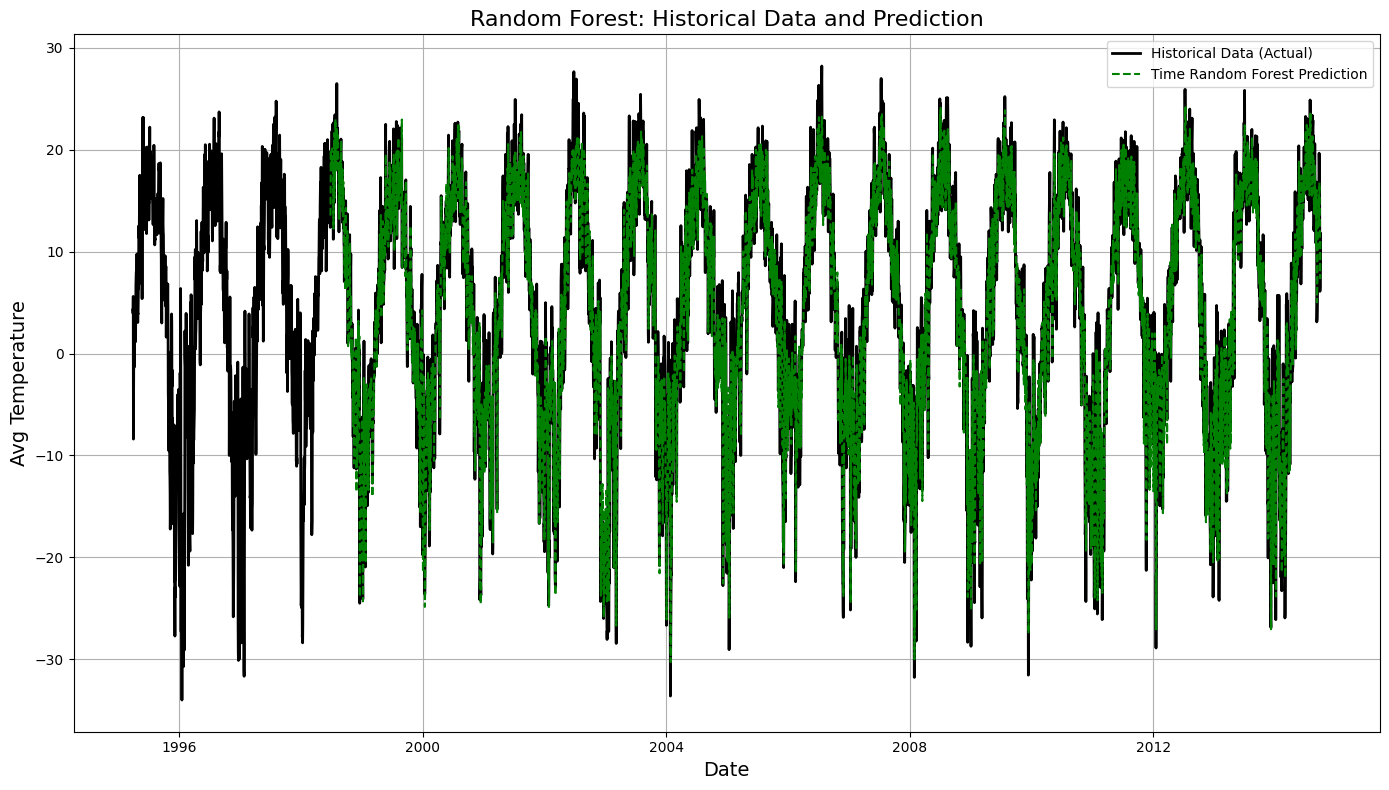

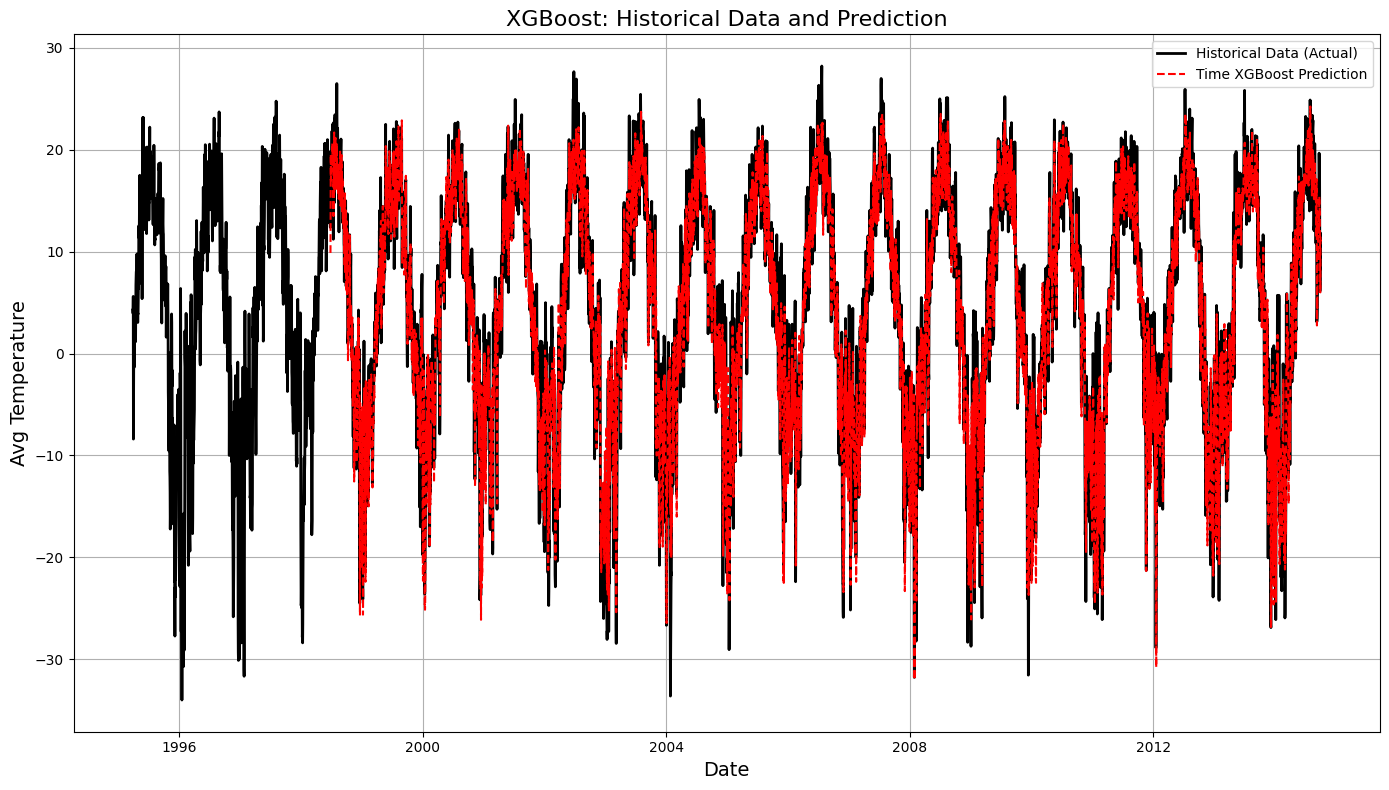

In [22]:
# Separate graphs for each model

# Plot for Linear Regression
plt.figure(figsize=(14, 8))
plt.plot(y_train.index, y_train, label='Historical Data (Actual)', color='black', linewidth=2)
plt.plot(y_train.index[len(y_train) - len(time_y_pred_linear):], time_y_pred_linear, label='Time Linear Regression Prediction', color='blue', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Avg Temperature', fontsize=14)
plt.title('Linear Regression: Historical Data and Prediction', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for Random Forest
plt.figure(figsize=(14, 8))
plt.plot(y_train.index, y_train, label='Historical Data (Actual)', color='black', linewidth=2)
plt.plot(y_train.index[len(y_train) - len(time_y_pred_rf):], time_y_pred_rf, label='Time Random Forest Prediction', color='green', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Avg Temperature', fontsize=14)
plt.title('Random Forest: Historical Data and Prediction', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for XGBoost
plt.figure(figsize=(14, 8))
plt.plot(y_train.index, y_train, label='Historical Data (Actual)', color='black', linewidth=2)
plt.plot(y_train.index[len(y_train) - len(time_y_pred_xgb):], time_y_pred_xgb, label='Time XGBoost Prediction', color='red', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Avg Temperature', fontsize=14)
plt.title('XGBoost: Historical Data and Prediction', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Feature Importance

### Linear Regression Model

<ipython-input-23-36427b39d29f>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


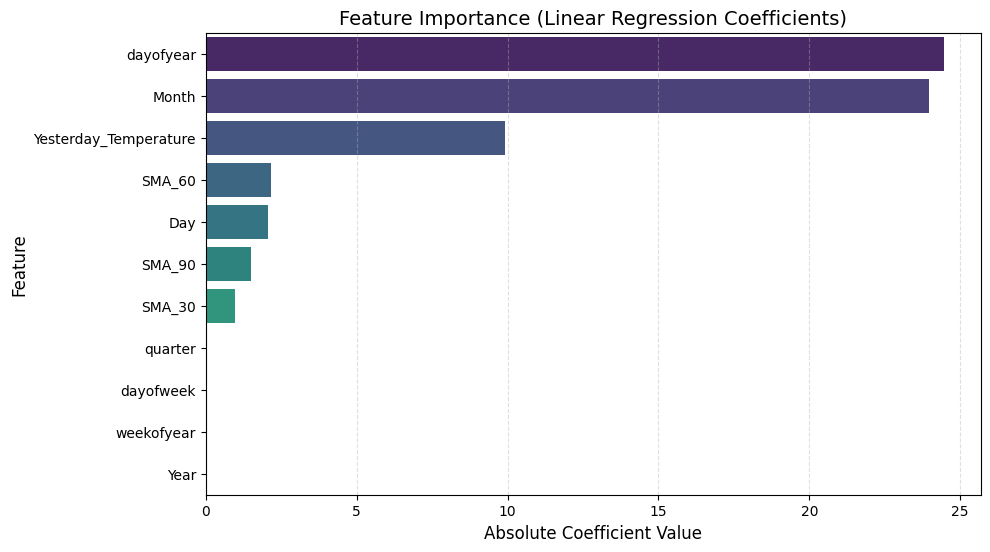

In [23]:
# Get coefficients
coefficients = linear_model.coef_

# Create DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(coefficients)  # Absolute value (magnitude matters)
}).sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance.sort_values('Importance', ascending=False),
    palette='viridis'
)
plt.title('Feature Importance (Linear Regression Coefficients)', fontsize=14)
plt.xlabel('Absolute Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()

### Random Forest Model

<ipython-input-24-e0af9b0be3e3>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')


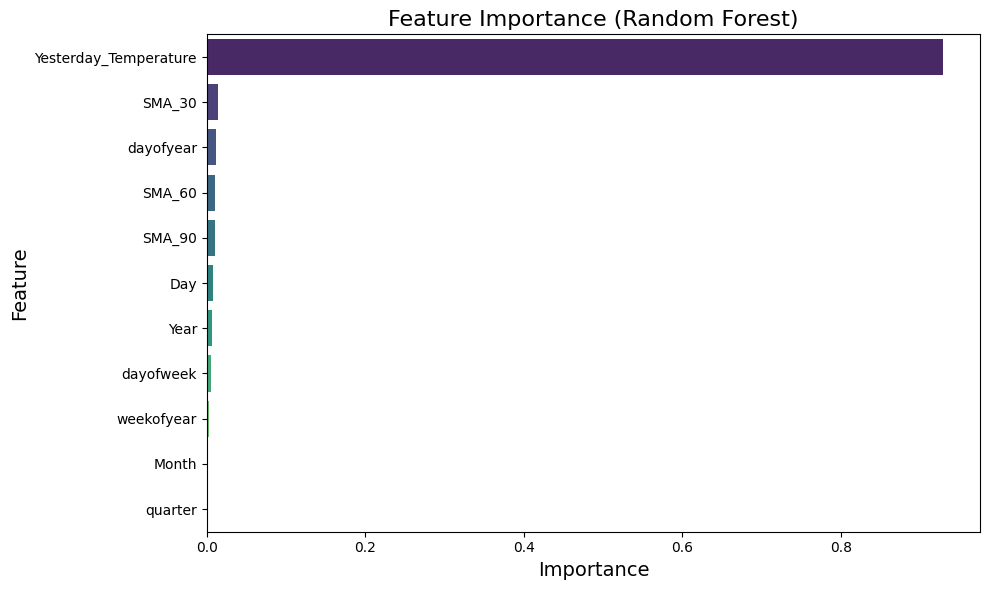

In [24]:
# Feature importance analysis (Random Forest)
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the features by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')
plt.title('Feature Importance (Random Forest)', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()


XGBoost Model

<ipython-input-25-426d278d2204>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')


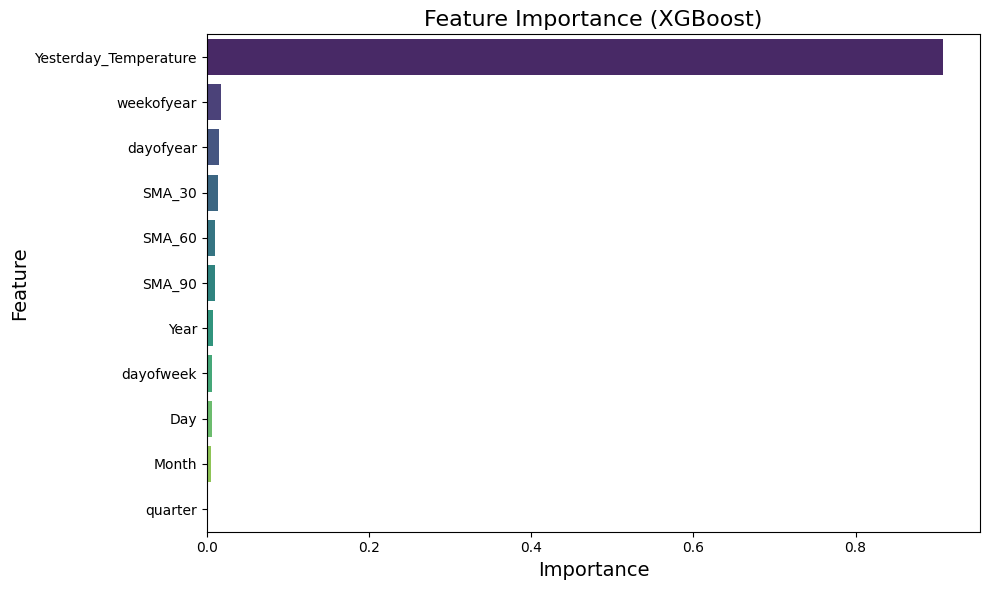

In [25]:
# Feature importance analysis (Random Forest)
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for feature importances
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the features by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')
plt.title('Feature Importance (XGBoost)', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()


### Time Series CV for Previous Models

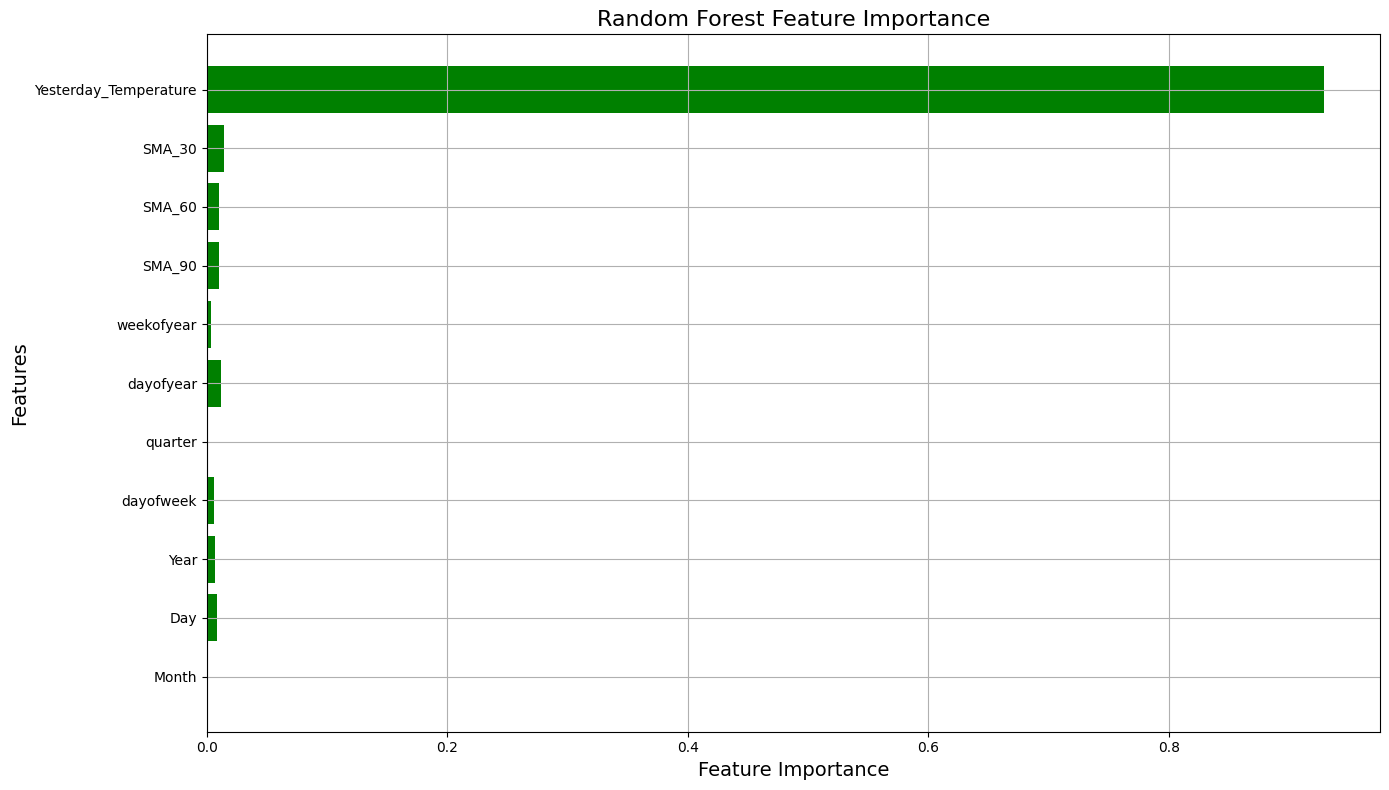

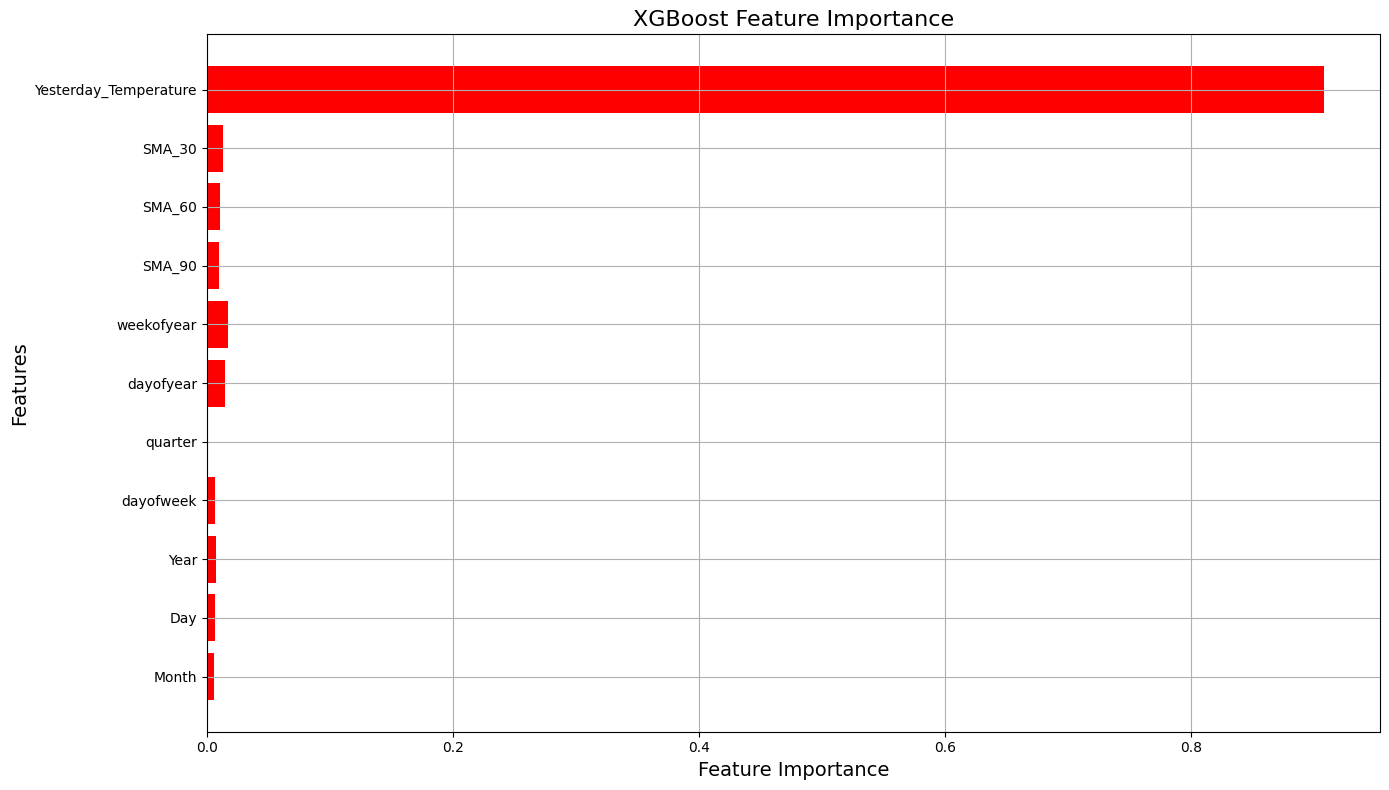

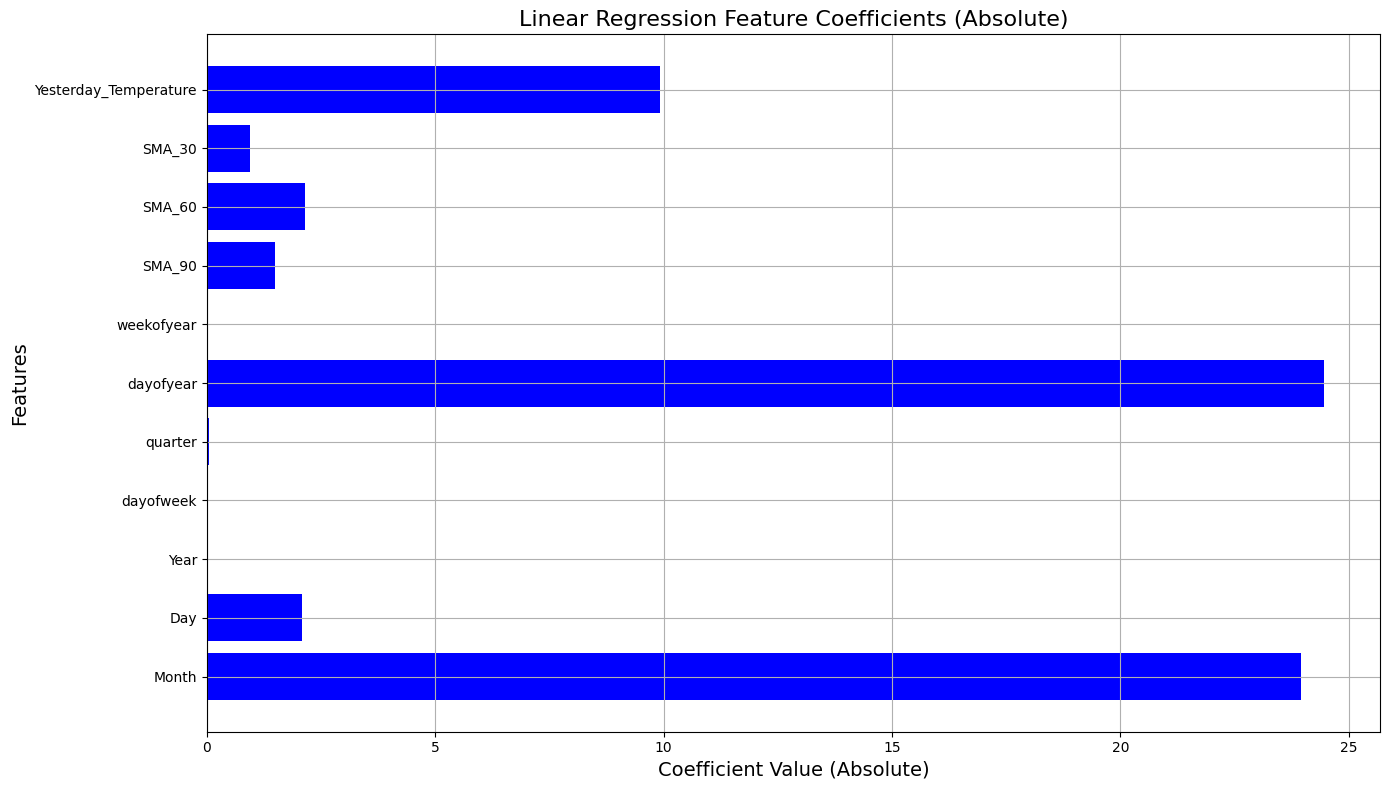

In [26]:
# Feature Importance for Random Forest
plt.figure(figsize=(14, 8))
plt.barh(X_train.columns, rf_model.feature_importances_, color='green')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Random Forest Feature Importance', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importance for XGBoost
plt.figure(figsize=(14, 8))
plt.barh(X_train.columns, xgb_model.feature_importances_, color='red')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('XGBoost Feature Importance', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Coefficients for Linear Regression (Using absolute value)
plt.figure(figsize=(14, 8))
plt.barh(X_train.columns, np.abs(linear_model.coef_), color='blue')  # Use absolute value
plt.xlabel('Coefficient Value (Absolute)', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Linear Regression Feature Coefficients (Absolute)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()



## Error Metrics Over Time

### Linear Regression Model

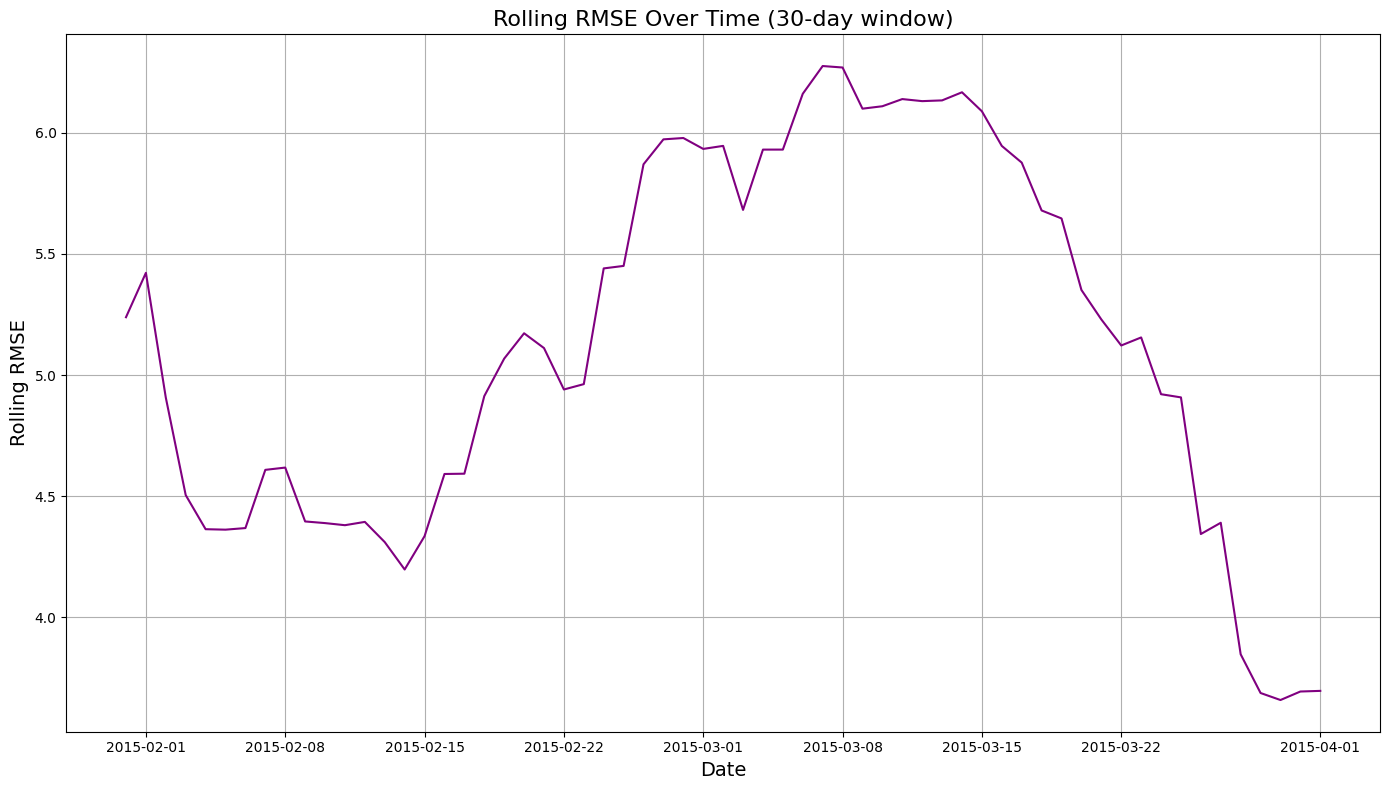

In [27]:
from sklearn.metrics import mean_squared_error

# Calculate rolling RMSE with a window size of 30 days
window_size = 30
rolling_rmse = []

for i in range(window_size, len(y_test)):
    y_true_window = y_test.iloc[i-window_size:i]
    y_pred_window = y_pred_linear[i-window_size:i]

    rmse = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse)

# Plot rolling RMSE
plt.figure(figsize=(14, 8))
plt.plot(y_test.index[window_size:], rolling_rmse, color='purple')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Rolling RMSE', fontsize=14)
plt.title('Rolling RMSE Over Time (30-day window)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


### Random Forest Model

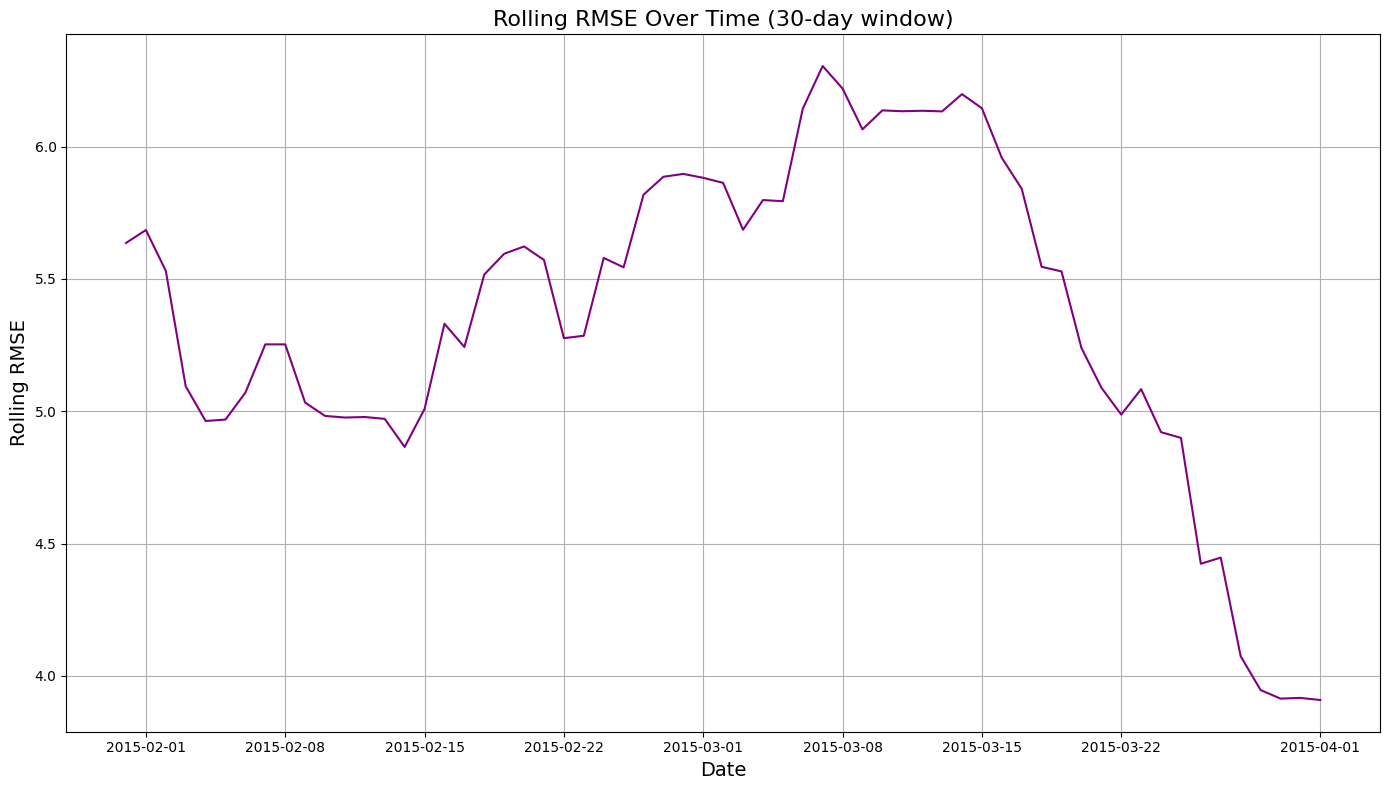

In [28]:
# Calculate rolling RMSE with a window size of 30 days
window_size = 30
rolling_rmse = []

for i in range(window_size, len(y_test)):
    y_true_window = y_test.iloc[i-window_size:i]
    y_pred_window = y_pred_rf[i-window_size:i]

    rmse = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse)

# Plot rolling RMSE
plt.figure(figsize=(14, 8))
plt.plot(y_test.index[window_size:], rolling_rmse, color='purple')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Rolling RMSE', fontsize=14)
plt.title('Rolling RMSE Over Time (30-day window)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


XGBoost Model

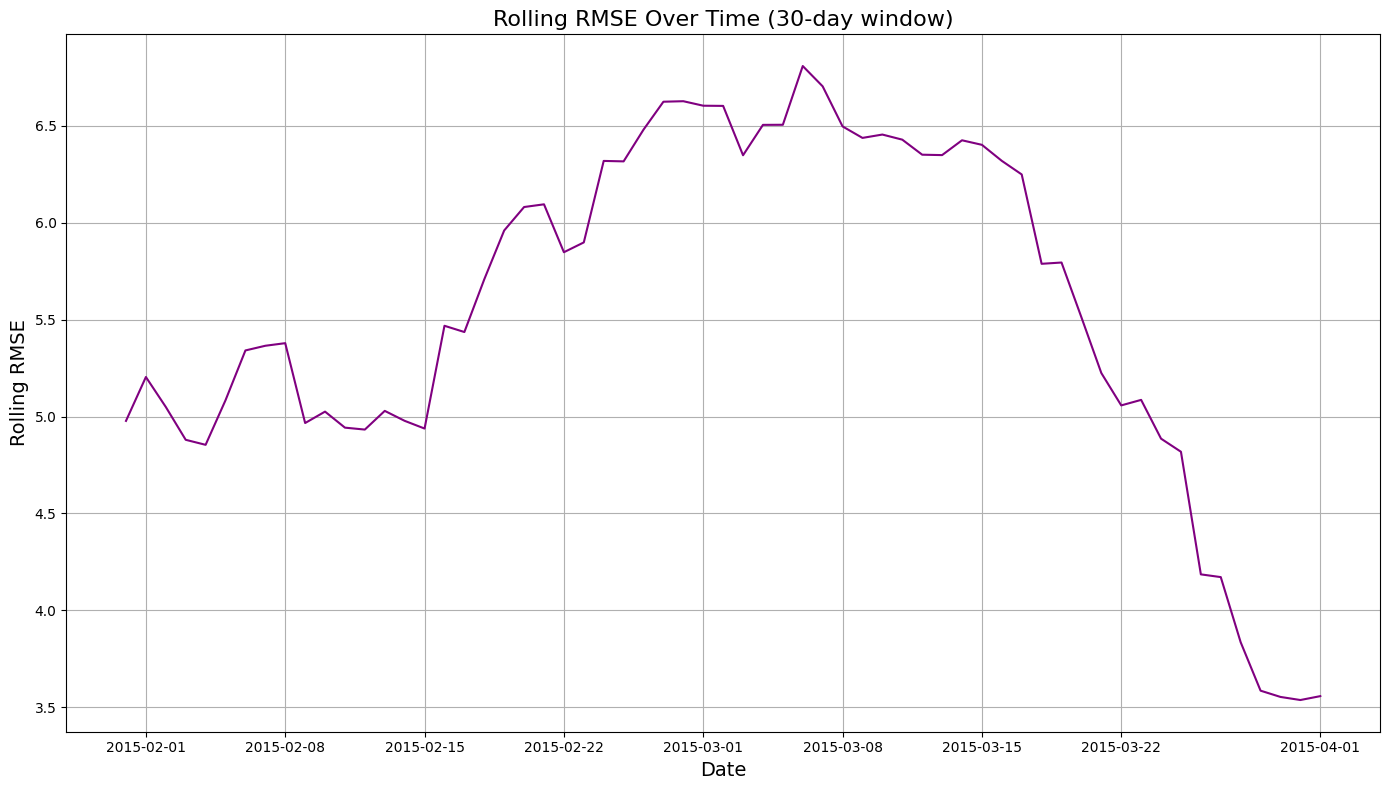

In [29]:
from sklearn.metrics import mean_squared_error

# Calculate rolling RMSE with a window size of 30 days
window_size = 30
rolling_rmse = []

for i in range(window_size, len(y_test)):
    y_true_window = y_test.iloc[i-window_size:i]
    y_pred_window = y_pred_xgb[i-window_size:i]

    rmse = np.sqrt(mean_squared_error(y_true_window, y_pred_window))
    rolling_rmse.append(rmse)

# Plot rolling RMSE
plt.figure(figsize=(14, 8))
plt.plot(y_test.index[window_size:], rolling_rmse, color='purple')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Rolling RMSE', fontsize=14)
plt.title('Rolling RMSE Over Time (30-day window)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


### Time Series CV for Previous Models

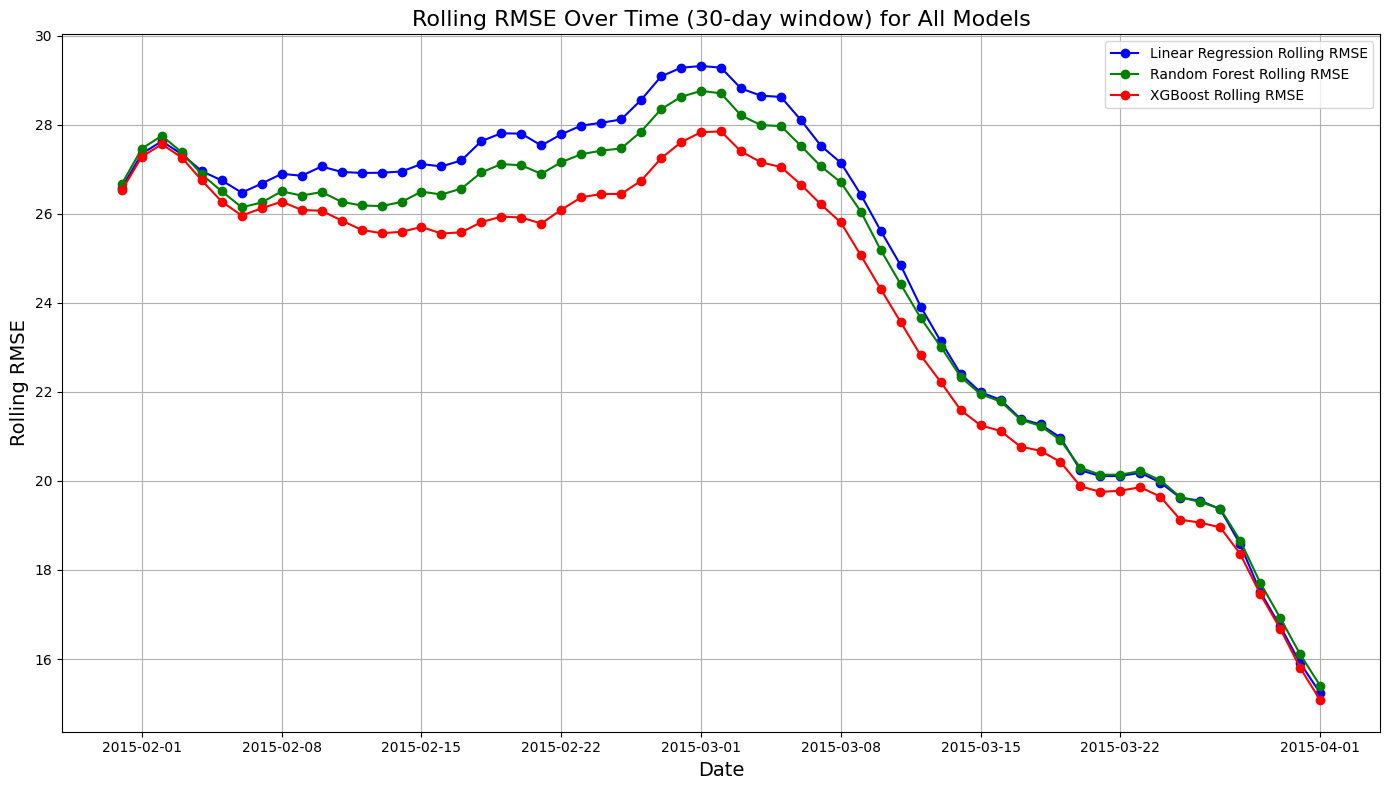

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate rolling RMSE with a window size of 30 days for all models
window_size = 30
rolling_rmse_linear = []
rolling_rmse_rf = []
rolling_rmse_xgb = []

# Linear Regression Rolling RMSE
for i in range(window_size, len(y_test)):
    y_true_window = y_test.iloc[i-window_size:i]
    y_pred_window_linear = time_y_pred_linear[i-window_size:i]
    rmse_linear = np.sqrt(mean_squared_error(y_true_window, y_pred_window_linear))
    rolling_rmse_linear.append(rmse_linear)

# Random Forest Rolling RMSE
for i in range(window_size, len(y_test)):
    y_true_window = y_test.iloc[i-window_size:i]
    y_pred_window_rf = time_y_pred_rf[i-window_size:i]
    rmse_rf = np.sqrt(mean_squared_error(y_true_window, y_pred_window_rf))
    rolling_rmse_rf.append(rmse_rf)

# XGBoost Rolling RMSE
for i in range(window_size, len(y_test)):
    y_true_window = y_test.iloc[i-window_size:i]
    y_pred_window_xgb = time_y_pred_xgb[i-window_size:i]
    rmse_xgb = np.sqrt(mean_squared_error(y_true_window, y_pred_window_xgb))
    rolling_rmse_xgb.append(rmse_xgb)

# Plotting Rolling RMSE Over Time for all models
plt.figure(figsize=(14, 8))

# Plot Rolling RMSE for Linear Regression
plt.plot(y_test.index[window_size:], rolling_rmse_linear, label='Linear Regression Rolling RMSE', color='blue', marker='o')

# Plot Rolling RMSE for Random Forest
plt.plot(y_test.index[window_size:], rolling_rmse_rf, label='Random Forest Rolling RMSE', color='green', marker='o')

# Plot Rolling RMSE for XGBoost
plt.plot(y_test.index[window_size:], rolling_rmse_xgb, label='XGBoost Rolling RMSE', color='red', marker='o')

# Labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Rolling RMSE', fontsize=14)
plt.title('Rolling RMSE Over Time (30-day window) for All Models', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
